## This notebook is for improving the measurement accuracy of the stereo vision algorithm and camera calibration

In [1]:
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
import pickle as pkl
import cv2
import numpy as np

class calibrator:
    
    def __init__(self, calibration_data:str):
        with open(calibration_data,'rb') as f:
            self.ret, self.mtx, self.dist, self.rvecs, self.tvecs, self.w, self.h= pkl.load(f)
            self.newcameramtx, self.roi = cv2.getOptimalNewCameraMatrix(self.mtx, self.dist, (self.w,self.h), 1, (self.w,self.h))

    def undistort(self, img:np.ndarray)->np.ndarray:
        dst = cv2.undistort(img, self.mtx, self.dist, None, self.newcameramtx)
        x, y, w, h = self.roi
        return dst[y:y+h, x:x+w]

In [3]:
calib = [calibrator("../calibration objects\cam1_calib.pkl"), calibrator("../calibration objects\cam2_calib.pkl")]

In [4]:
images = [cv2.imread("./cam1_points.jpg"), cv2.imread("./cam2_points.jpg")]
images_undistorted = [calib[0].undistort(images[0]), calib[1].undistort(images[1])]

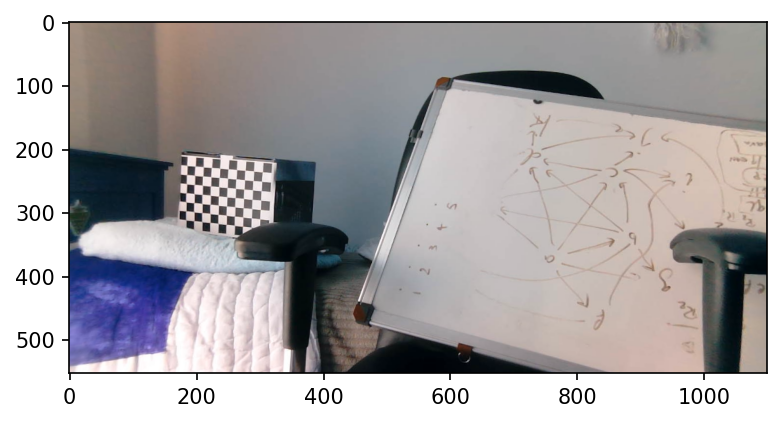

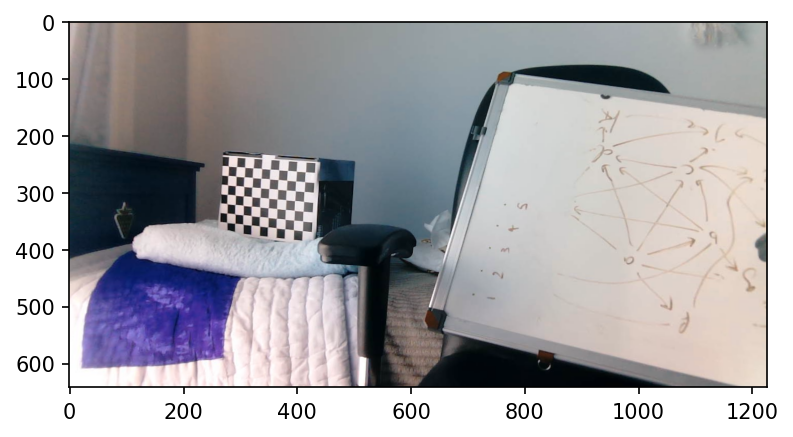

In [5]:
for image in images_undistorted:
    plt.figure(dpi=150)
    plt.imshow(image)

In [6]:
cam1_points = [(576, 480),(592 ,442),(608, 404), (624, 365) ,(640, 327)] # without subpixel correction 
cam2_points = [(706, 438),(719 ,400),(732, 363), (745, 328) ,(757, 295)] # without subpixel correction 

(553, 1099, 3)


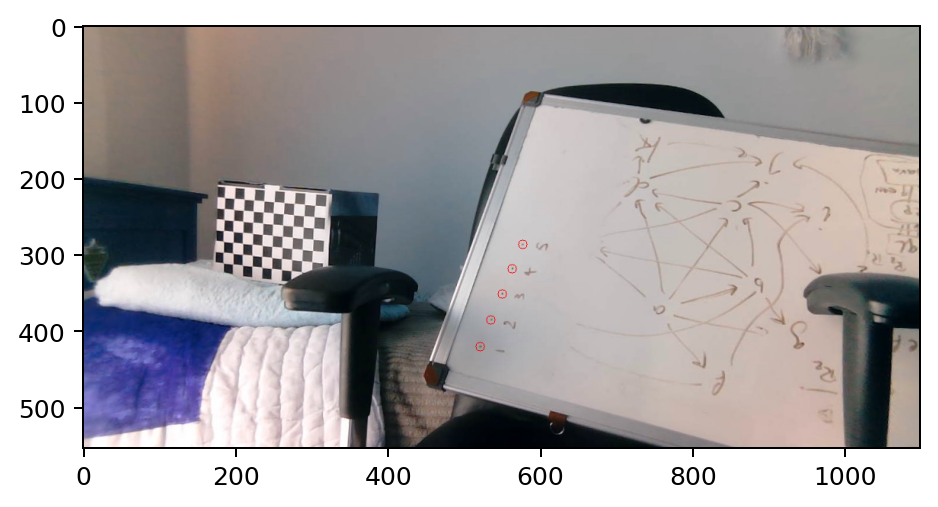

In [7]:
cam1_points = [(521, 421),(535 ,386),(550, 352), (563, 319) ,(577, 287)]
test_img = images_undistorted[0].copy()
print(test_img.shape)
for point in cam1_points:
    cv2.circle(test_img, point, 6, (255, 0, 0), 1)
plt.figure(dpi=180)
plt.imshow(test_img)

(642, 1226, 3)


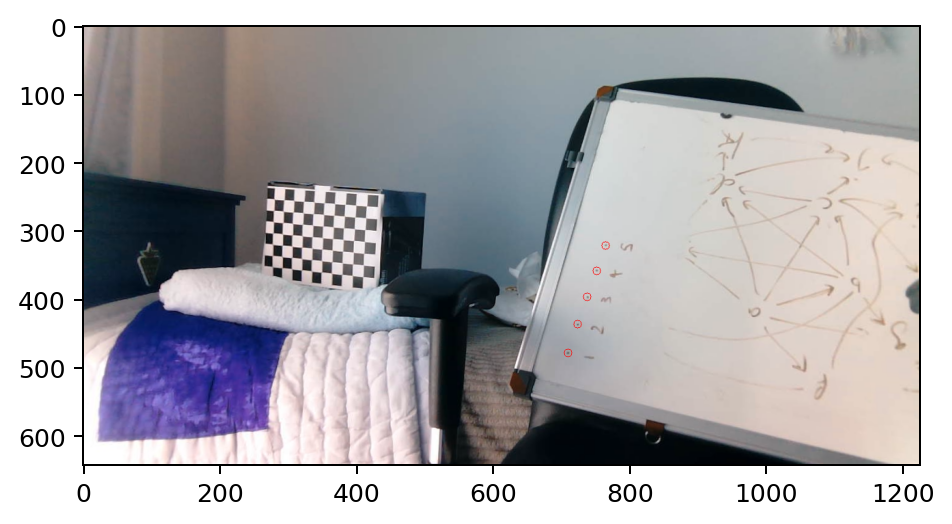

In [8]:
cam2_points = [(710, 479),(724 ,437),(738, 397), (752, 359) ,(765, 322)]
test_img = images_undistorted[1].copy()
print(test_img.shape)
for point in cam2_points:
    cv2.circle(test_img, point, 6, (255, 0, 0), 1)
plt.figure(dpi=180)
plt.imshow(test_img)

(642, 1226, 3)


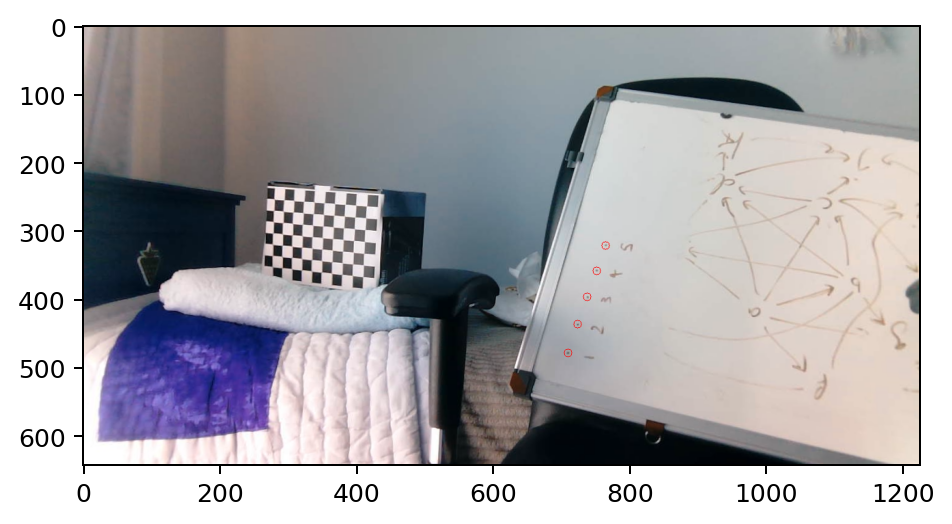

In [9]:
zpoints_1 = [(710, 479),(724 ,437),(738, 397), (752, 359) ,(765, 322)]
test_img = images_undistorted[1].copy()
print(test_img.shape)
for point in cam2_points:
    cv2.circle(test_img, point, 6, (255, 0, 0), 1)
plt.figure(dpi=180)
plt.imshow(test_img)

In [16]:
def dist(p1, p2): # calculates the distance between 2 points in 3d space
    dx = (p1[0] - p2[0]) ** 2
    dy = (p1[1] - p2[1]) ** 2
    dz = (p1[2] - p2[2]) ** 2
    return (dx + dy + dz) ** 0.5

def getVariance(arr): # calculates the variance 
    mean = sum(arr) / len(arr)
    summ = 0
    for x in arr:
        summ+=(x-mean)**2
    return (summ/len(arr))**0.5

In [17]:
a = [4, 8, 12]
b = [2, 4, 6]
print(getVariance(b))
print(getVariance(a))

1.632993161855452
3.265986323710904


In [14]:
x_plt = []
y_plt = []

f = 1 # actual value must be measured
l = len(cam1_points)
baseline = 9 # in Cm
disparity_zero = False

for disparity_shift in range(-100, 100):
    pos3d = []
    for i in range(l):
        disparity = abs(cam1_points[i][0] - cam2_points[i][0] + disparity_shift)
        if disparity == 0:
            disparity_zero = True
            break
        z = (baseline * f) / disparity
        x = cam1_points[i][0] * baseline / disparity
        y = x / cam1_points[i][0] * (cam1_points[i][1] + cam2_points[i][1]) / 2
        pos3d.append((x, y, z))

    if disparity_zero:
        continue

    distance3d = []
    for i in range(l-1):
        distance3d.append(dist(pos3d[i], pos3d[i+1]))
    mean_distance = sum(distance3d) / (l - 1)
    distance3d_normalised = [x * 4 / mean_distance for x in distance3d]
    
    y_plt.append(get_error(distance3d_normalised))
    x_plt.append(disparity_shift)

Text(0, 0.5, 'Error')

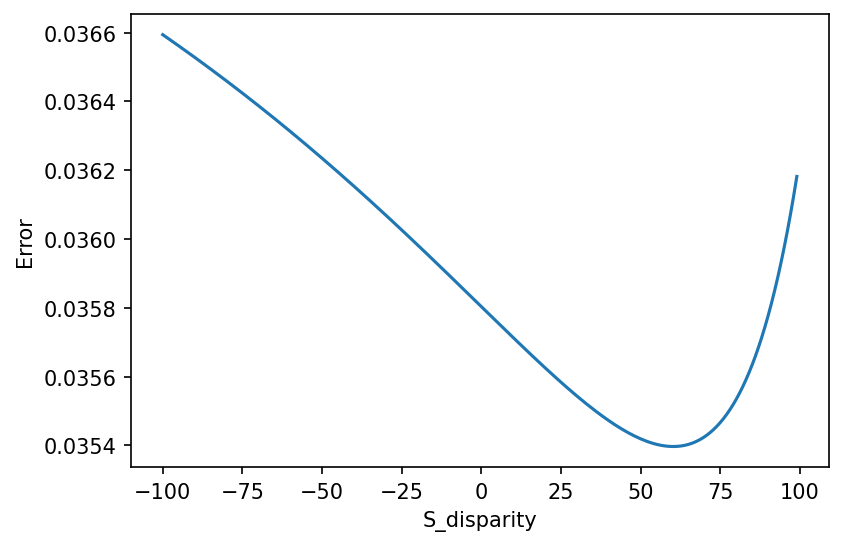

In [15]:
import matplotlib.pyplot as plt

plt.figure(dpi = 150)
plt.plot(x_plt, y_plt)
plt.xlabel("S_disparity")
plt.ylabel("Error")

In [16]:
miny = 100000
miny_index = 0
for i, y in enumerate(y_plt):
    if y < miny:
        miny = y
        miny_index = i

print(f"{miny} for shift = {x_plt[miny_index]}")

0.03539705675923498 for shift = 60


In [95]:
shift_optimum = x_plt[miny_index]
l = len(cam1_points)
f = 1.0157791196778294 # focal point in cm
baseline = 9
pos3d = []
disparity_zero = False
for i in range(l):
    disparity = abs(cam1_points[i][0] - cam2_points[i][0] + disparity_shift)
    if disparity == 0:
        disparity_zero = True
        break
    z = (baseline * f) / disparity
    x = cam1_points[i][0] * baseline / disparity
    y = x / cam1_points[i][0] * (cam1_points[i][1] + cam2_points[i][1]) / 2
    pos3d.append((x, y, z))

distance3d = []
for i in range(l-1):
    distance3d.append(dist(pos3d[i], pos3d[i+1]))
mean_distance = sum(distance3d) / (l - 1)
mean_distance

3.9378639769737362

In [ ]:
zimages = [cv2.imread("cam1_z.jpg"), cv2.imread("cam2_z.jpg")]
